# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [1]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [ ]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [5]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [6]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data

In [7]:
train_X = load_dataset(context, 'train/housing/features')
train_y = load_dataset(context, 'train/housing/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/housing/features')
test_y = load_dataset(context, 'test/housing/target')
print(test_X.shape, test_y.shape)

(16512, 12) (16512, 1)
(4128, 12) (4128, 1)


## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [8]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [9]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(16512, 12)
(16512, 12)


#### Encoding


Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

In [10]:
oh_enc_simple_impt = Pipeline([
    ('one_hot_encoding', OneHotEncoder()),
    ('simple_impute', SimpleImputer(strategy='most_frequent')),
])


simple_impute_std_scale = Pipeline(
    [
        ('simple_impute', SimpleImputer(strategy='median')),
        ('standard_scalar', StandardScaler())
    ]
)

# NOTE: the list of transformations here are not sequential but weighted
# (if multiple transforms are specified for a particular column)
# for sequential transforms use a pipeline as shown above.
features_transformer = ColumnTransformer([

    ## categorical columns
    ('oh_enc_simple_imputer', oh_enc_simple_impt, list(set(cat_columns))),

    ## numeric columns
    ('simple_impute_std_scale', simple_impute_std_scale, num_columns),

])


**Dev notes(Encoding):**
<details>

    Some common practices followed in Categorical Feature Encoding are
    * For categorical variables with too many levels, target encoding can be done.
    * For fewer levels, one hot encoding can be done.
    * If one very dominant level is observed, binary encoding can be used.
    
    
</details>

## 3.2 Feature analysis

Using the pipeline above analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

In [11]:
sample_X = train_X.sample(frac=0.1, random_state=context.random_seed)
sample_y = train_y.loc[sample_X.index]

sample_train_X = get_dataframe(
    features_transformer.fit_transform(sample_X, sample_y),
    list(features_transformer.transformers_[0][1][0].get_feature_names_out()) + list(num_columns)
)

# nothing to do for target
sample_train_y = sample_y

Running the features transformer on the complete data

In [12]:
train_X = get_dataframe(
    features_transformer.fit_transform(train_X, train_y),
    list(features_transformer.transformers_[0][1][0].get_feature_names_out()) + list(num_columns)
)

In [13]:
train_X.head().T

,0,1,2,3,4
ocean_proximity_<1H OCEAN,1.000000,1.000000,0.000000,0.000000,0.000000
ocean_proximity_INLAND,0.000000,0.000000,0.000000,1.000000,1.000000
ocean_proximity_ISLAND,0.000000,0.000000,0.000000,0.000000,0.000000
ocean_proximity_NEAR BAY,0.000000,0.000000,1.000000,0.000000,0.000000
ocean_proximity_NEAR OCEAN,0.000000,0.000000,0.000000,0.000000,0.000000
longitude,-1.650449,0.610133,-1.425888,0.240854,-1.026668
latitude,1.336628,-0.749932,1.013819,-0.141742,2.880494
housing_median_age,-0.128215,1.624665,1.863694,-1.642065,0.907578
total_rooms,0.771483,-0.546425,0.465798,3.790882,0.412735
total_bedrooms,0.731054,-0.439148,1.667216,3.672745,0.404554


In [14]:
train_X.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_1H OCEAN'}, inplace=True)

### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [15]:
out = eda.get_density_plots(train_X, cols=['ocean_proximity_<1H OCEAN', 'median_income'])
out

:Layout
   .Overlay.I :Overlay
      .Histogram.I    :Histogram   [x]   (Frequency)
      .Distribution.I :Distribution   [median_income]   (Density)
   .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [16]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

A report containing the above plot is available [here](https://drive.google.com/file/d/16ntqUc_zvpg0at5pTtO-ljBjw5UVGFnp/view?usp=sharing)


Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1vUaCcs1PJ4IYo1em9-eZIEj9WuDsnFKT/view?usp=sharing)

In [17]:
reports.feature_analysis(train_X,'./feature_analysis_report.html')

p-value may not be accurate for N > 5000.


### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [18]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,households,total_bedrooms,0.973557,0.973557
1,latitude,longitude,-0.924918,0.924918
2,total_bedrooms,total_rooms,0.919087,0.919087
3,households,total_rooms,0.913502,0.913502
4,households,population,0.907971,0.907971
5,population,total_bedrooms,0.873697,0.873697
6,population,total_rooms,0.844430,0.844430
7,bedrooms_per_room,rooms_per_household,-0.751673,0.751673
8,bedrooms_per_room,median_income,-0.675388,0.675388
9,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,-0.606939,0.606939


In [19]:
# High corelation for total_bedrooms variable so removing it
curated_columns = list(
    set(train_X.columns.to_list())
    - set(['total_bedrooms'])
)

train_X = train_X[curated_columns]

out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,latitude,longitude,-0.924918,0.924918
1,households,total_rooms,0.913502,0.913502
2,households,population,0.907971,0.907971
3,population,total_rooms,0.844430,0.844430
4,bedrooms_per_room,rooms_per_household,-0.751673,0.751673
5,bedrooms_per_room,median_income,-0.675388,0.675388
6,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,-0.606939,0.606939


In [20]:
out = eda.get_bivariate_plots(train_X, x_cols=['households'], y_cols=['population'])
out

:HexTiles   [households,population]

In [21]:
%%time
# create reports as needed
cols = train_X.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols):
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

CPU times: user 34.3 s, sys: 40.4 s, total: 1min 14s
Wall time: 22.2 s


A report containing the bivariate plot is available [here](https://drive.google.com/file/d/1WSGT3586tY-rOmZ57xGILbmL5ll9cSVT/view?usp=sharing)

Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1A2fz_bjYv8I3iaFDT75JQSDKeJEXxCtp/view?usp=sharing)

In [22]:
reports.feature_interactions(train_X,'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

In [23]:
out = eda.get_target_correlation(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

In [24]:
train_y['median_house_value']

0        187800.0
1        136600.0
2        400000.0
3        106300.0
4         43500.0
           ...   
16507    132300.0
16508    101300.0
16509    500001.0
16510    244900.0
16511    117600.0
Name: median_house_value, Length: 16512, dtype: float64

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
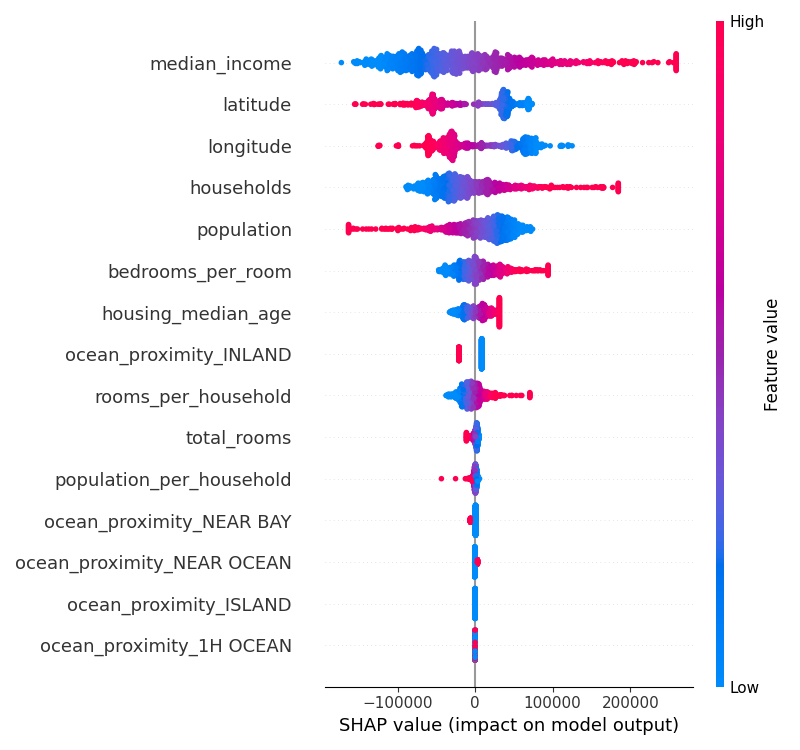

In [25]:
out = eda.get_feature_importances(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Key drivers report like feature importance, bivariate plots can be obtained as below

In [26]:
reports.key_drivers(train_X,train_y, './key_drivers_report.html', y_continuous=True)

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.
- The plot with shap is present [here](https://drive.google.com/file/d/1JOTMBLiv3LEqZ-kxZz0RokW9v5UyiGva/view?usp=sharing)

</details>


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1209MzmSSEhiTYuPfHpaVXFXUVbkaJm0B/view?usp=sharing)

In [27]:
reports.data_exploration(train_X,train_y,'./data_exploration_report.html', y_continuous=True)

p-value may not be accurate for N > 5000.


In [28]:
# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [29]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [30]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

### 4.1.2 Data transformations

In [31]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data

    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [32]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7fa492143940>,
                                     kw_args={'cols2keep': ['rooms_per_household',
                                                            'ocean_proximity_1H '
                                                            'OCEAN',
                                                            'bedrooms_per_room',
                                                            'longitude',
                                                            'ocean_proximity_NEAR '
                                                            'BAY',
                                                            'total_rooms',
                                                            'population_per_household',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'housing_median_age',
                                                            'population',
                                                            'ocean_proximity_ISLAND',
                                                            'median_income',
                                                            'ocean_proximity_INLAND']})),
                ('estimator', SKLStatsmodelOLS())])

In [33]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     2678.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:25:19   Log-Likelihood:            -2.0698e+05
No. Observations:               16512   AIC:                         4.140e+05
Df Residuals:                   16499   BIC:                         4.141e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                   2.066e+05   5628.713     36.707      0.000    1.96e+05    2.18e+05
rooms_per_household          690.3040    931.784      0.741      0.459   -1136.093    2516.700
ocean_proximity_1H OCEAN    1.717e+04   5677.304      3.024      0.002    6040.338    2.83e+04
bedrooms_per_room           3.076e+04    914.732     33.625      0.000     2.9e+04    3.26e+04
longitude                  -4513.6920    615.048     -7.339      0.000   -5719.253   -3308.131
ocean_proximity_NEAR BAY     1.24e+04   5832.897      2.126      0.034     968.352    2.38e+04
total_rooms                 3.124e+04   1586.802     19.688      0.000    2.81e+04    3.44e+04
population_per_household   -9005.2223    685.486    -13.137      0.000   -1.03e+04   -7661.596
ocean_proximity_NEAR OCEAN  2.956e+04   5752.960      5.139      0.000    1.83e+04    4.08e+04
housing_median_age          1.729e+04    609.439     28.372      0.000    1.61e+04    1.85e+04
population                 -2.516e+04   1553.287    -16.200      0.000   -2.82e+04   -2.21e+04
ocean_proximity_ISLAND      1.879e+05   2.81e+04      6.696      0.000    1.33e+05    2.43e+05
median_income               8.902e+04    835.669    106.526      0.000    8.74e+04    9.07e+04
ocean_proximity_INLAND     -4.044e+04   5708.153     -7.085      0.000   -5.16e+04   -2.93e+04
==============================================================================
Omnibus:                     3948.544   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12857.262
Skew:                           1.208   Prob(JB):                         0.00
Kurtosis:                       6.585   Cond. No.                     1.99e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [34]:
testx = load_dataset(context, 'test/housing/features')

In [35]:
testx = features_transformer.transform(test_X)

In [36]:
curated_columns

['households',
 'rooms_per_household',
 'ocean_proximity_1H OCEAN',
 'latitude',
 'bedrooms_per_room',
 'longitude',
 'ocean_proximity_NEAR BAY',
 'total_rooms',
 'population_per_household',
 'ocean_proximity_NEAR OCEAN',
 'housing_median_age',
 'population',
 'ocean_proximity_ISLAND',
 'median_income',
 'ocean_proximity_INLAND']

In [37]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])

test_X = get_dataframe(
    features_transformer.transform(test_X),
    list(features_transformer.transformers_[0][1][0].get_feature_names_out()) + list(num_columns)
)

In [38]:
test_X.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_1H OCEAN'}, inplace=True)

In [39]:
test_X = test_X[curated_columns]

In [40]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [41]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [42]:
residual_analysis.hvplot.kde(y="households",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="households",
                                title=f'unit cost(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [households]   (Density)

- From the above plot we can infer that the higher "over predictions" are happening for unit_cost > 200.
- similarly, the higher "under predictions" are happening for unit_cost is zero.

This can help us tune the model by a separate model for unit_cost > 200


# 4.2 Modelling - XGBoost

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [43]:
# let's find features for some decent defaults
from xgboost import XGBRegressor

estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### 4.2.3 Model Tuning

<AxesSubplot:>

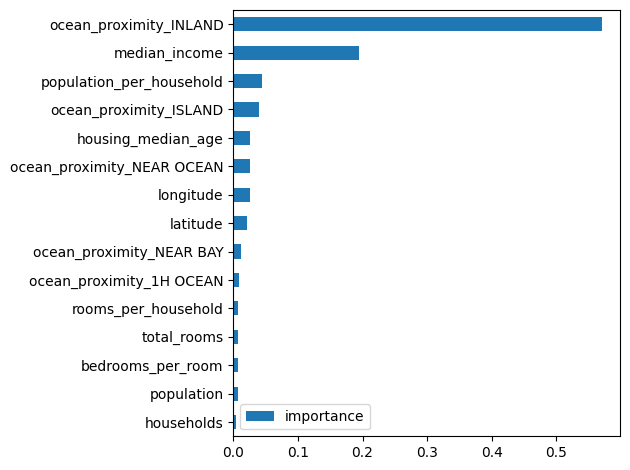

In [44]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

'condition','model_family','days_since_last_purchase','first_time_customer','sales_person', are considered to be important and in grid search

##### Pipeline build based on new importance features

In [45]:
# let's find features for some decent defaults
imp_features = ['ocean_proximity_INLAND','median_income','ocean_proximity_ISLAND','population_per_household','housing_median_age','ocean_proximity_NEAR OCEAN', 'latitude', 'longitude']

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', XGBRegressor())
])

#### Grid Search of the Estimator

In [ ]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500],
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

#### Pipeline Build using the best estimator

In [47]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7fa492143940>,
                                     kw_args={'cols2keep': ['ocean_proximity_INLAND',
                                                            'median_income',
                                                            'ocean_proximity_ISLAND',
                                                            'population_per_household',
                                                            'housing_median_age',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'latitude',
                                                            'longitude']})),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsamp...
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [48]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')

The Regression report containing the feature importances are available [here](https://drive.google.com/file/d/1JBfL3uxPcxBfl0amweXBFmLr7CSHFBUO/view?usp=sharing)

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [49]:
yhat_reg = reg_ppln.predict(test_X)
yhat_xgb = xgb_pipeline_final.predict(test_X)

In [50]:
model_comparison_report = RegressionComparison(
    y=test_y, yhats={
        'Linear Regression': yhat_reg,
        'XGBoost': yhat_xgb
})
metrics = model_comparison_report.get_report(file_path='regression_comparison')

In [51]:
model_comparison_report.performance_metrics

metric,MAPE,WMAPE,MAE,RMSE,R^2
Linear Regression,0.2925,0.2472,51276.3642,97587.3808,0.2809
XGBoost,0.1782,0.1562,32400.7286,47983.8814,0.8262


A report comparing the performance, metrics between Linear model and Tree model are available [here](https://drive.google.com/file/d/1LDibiFap9K4DKME-Y0S0mtI_05lTdaJF/view?usp=sharing)

**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges

In this example we are choosing LM model for pipelining. General criteria for choosing production models is:

- Parametric models (aka whitebox models) such as Linear Regression are easier to explain to non-technical audience.
- Generally these are accepted fast and adoption is quicker.
- If the downstream calls for optimization using these models parametric models are easier to implement.
- When accuracy is primary goal without explainability, the above two takes a backseat